<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/GSOC_EQNN_MAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EQUIVARIANT QUANTUM NEURAL NETWORKS

1. Definir la simetría del problema.
2. Construir embeddings de datos que respeten esta simetría.
3. Transformar las puertas cuánticas estándar en puertas equiviariantes.
4. Implementar capas equiviariantes en el circuito cuántico.
5. Asegurar que la salida del modelo sea invariante bajo las transformaciones de simetría.

In [ ]:
%%capture
pip install pennylane==0.35.0

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from matplotlib import colors

# SO(N)
The Special Orthogonal group, $SO(n)$, corresponds to the set of all the matrix rotations $R(\theta)$ in n dimensions. Special comes from the fact that the rotations have determinant +1  and Orthogonal means that $R^T R = \mathbb{I}$.

Furthermore, because SO(n) is a Lie group then it has to obey the following properties:
1. Rotation is linear. $R(v+w)=R(v)+R(w)$
2. Preserves lengths and angles. $(Rv)\cdot(Rw) = v\cdot w$.
3. Preserves orientation. $det(R)=+1$

$$SO(n) = \{ R\in O(n), det(R)=1 \}$$





## SO(2)

Below is the explanation of the structure of the equivariant quantum neural network with SO(2) symmetry.

1. **Data Embedding:**

In this layer, classical data is encoded using the `embedding_layer(X)` function, where \( X \) is an array of size (10,3), meaning 10 rows and 3 columns. Each row is encoded with a qubit, and each feature with a rotation. The first rotation \( RZ \) is repeated twice with the third feature.

Example:

0 ----RZ(X[0,2])----RY(X[0,0])----RX(X[0,1])----RZ(X[0,2])----

1 ----RZ(X[1,2])----RY(X[1,0])----RX(X[1,1])----RZ(X[1,2])----

2 ----...

3 ----...
.

.

.

2. **Matrix rotations and trainable blocks:**

In this layer, rotation gates are applied:
$$ U = R(\theta) = \begin{pmatrix} 1 & 0 &0 &0 \\ 0 & \cos{\theta} & \sin{\theta} & 0 \\ 0 & -\sin{\theta} & \cos{\theta} & 0 \\ 0 & 0 & 0 & 1  \end{pmatrix} $$
This operator is of dimension 4x4 because it acts on seemingly two qubits; however, by mathematically expanding this, we observe the following:

$$ U(\theta)(|\psi_1⟩\otimes |\psi_2⟩) = \begin{pmatrix} 1 & 0 &0 &0 \\ 0 & \cos{\theta} & \sin{\theta} & 0 \\ 0 & -\sin{\theta} & \cos{\theta} & 0 \\ 0 & 0 & 0 & 1  \end{pmatrix} \begin{pmatrix} |\psi_1⟩ \\ |\psi_2⟩  \end{pmatrix} = \begin{pmatrix} 1 & 0 &0 &0 \\ 0 & \cos{\theta} & \sin{\theta} & 0 \\ 0 & -\sin{\theta} & \cos{\theta} & 0 \\ 0 & 0 & 0 & 1  \end{pmatrix}  \begin{pmatrix} \psi_{1_x} \psi_{2_x} \\ a\psi_{1_x} \psi_{2_x} + b\psi_{1_x} \psi_{2_y} \\ -b\psi_{1_y} \psi_{2_x} + a\psi_{1_y} \psi_{2_y}  \\  \psi_{1_y} \psi_{2_y}  \end{pmatrix} $$
Carrying out the matrix multiplication, we obtain:

$$ U \left( \left| \psi_1 \right\rangle \otimes \left| \psi_2 \right\rangle \right) = \begin{pmatrix} \psi_{1_x} \psi_{2_x} \\ a\psi_{1_x} \psi_{2_x} + b\psi_{1_x} \psi_{2_y} \\ -b\psi_{1_y} \psi_{2_x} + a\psi_{1_y} \psi_{2_y}  \\  \psi_{1_y} \psi_{2_y}  \end{pmatrix} $$

In general,

$$ U_{total} = U_{rbs}^{(0,1)}(\theta_0)\cdot U_{rbs}^{(1,2)}(\theta_1)\cdot...\cdot U_{rbs}^{(N-2,N-1)}(\theta_{N-2})\cdot U_{rbs}^{(N-1,0)}(\theta_{N-1}) $$

where $ U_{rbs}^{(i,j)}(\theta_i)$ is the rotation operation between qubits $i$ and $j$ with angle $\theta_i$.

3. **Pooling layer:**

Here, pooling layers are applied consisting of Controlled-Y gates, which halve the dimension of information in half of the qubits.

For example, first, we apply CY to 10 qubits, leaving us with 5 CY gates applied to the first 5 qubits, controlled by the last 5 qubits. Then, the same is done over 5 qubits, making the first two qubits the target qubits and the remaining 3 qubits the control qubits.

4. **Measurements:**

Finally, the measurement of the expected value with respect to the observable is performed. In this case, the observables are:

$$O_1 = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\ 0 & \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} & 0 \\ 0 & 0 & 0 & 1     \end{pmatrix} , \quad \quad O_2 = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & -\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\ 0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\ 0 & 0 & 0 & 1     \end{pmatrix}$$

This observable is measured with respect to the state of two qubits:

$$⟨y⟩ = ⟨\psi_1, \psi_2|O|\psi_1, \psi_2 ⟩ $$

Finally, this quantity is passed to the cost function to carry out the optimization process by updating the parameters \( \theta_i \) with each epoch.


In [ ]:
def embedding_layer(X):
    for i in range(X.shape[0]):
        qml.RZ(-1*X[i,2],wires=i)
        qml.RY(X[i,0],wires=i)
        qml.RX(X[i,1],wires=i)
        qml.RZ(X[i,2],wires=i)

def rbs(theta, wires):
    a = np.cos(theta)
    b = np.sin(theta)
    #R = np.array([[1, 0, 0, 0], [0, a, b, 0], [0, -b, a, 0], [0, 0, 0, 1]], requires_grad=True)
    R = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0,0, a, b], [0, 0, -b, a]], requires_grad=True)
    qml.QubitUnitary(R, wires=wires)

def XY_layer(N,params):
    for i in range(N-1):
#         qml.IsingXY(params[i],wires = [i,i+1])
#     qml.IsingXY(params[N-1],wires = [N-1,0])
        rbs(params[i],wires = [i,i+1])
    rbs(params[N-1],wires = [N-1,0])

def Y_pooling(N):
    n2 = N//2
    for i in range(n2):
        qml.CY(wires=[i+n2, i])

**Aqui consideramos la matriz de rotacion de 2x2 que actua sobre un solo qubit**


In [ ]:
## Aqui consideramos la matriz de rotacion de 2x2 que actua sobre un solo qubit

#def rbs(theta, wires):
#    a = np.cos(theta)
#    b = np.sin(theta)
#    R = np.array([ [a, b], [-b, a]], requires_grad=True)
#    qml.QubitUnitary(R, wires=wires)

#def XY_layer(N,params):
#    for i in range(N-1):
#        rbs(params[i],wires = [i])
#    rbs(params[N-1],wires = [N-1])

In [ ]:
dev = qml.device("default.qubit", wires=10)



def process_data2(Data):
    Data[:,:,0]*=(1/250)
    Index = Data[:,:,2]-2*np.pi>0
    Data[Index,2]-= 2*np.pi
    Index2 = Data[:,:,2]<0
    Data[Index2,2]+= 2*np.pi
    Data[:,:,2]-=np.pi
    return np.array(Data[:,:,:3])


Path =  '/content/'

# datos de quark-gluon
Data = np.load(Path+'Sorted_10_data.npy')
Label = np.load(Path+'Sorted_10_label.npy')
Data = process_data2(Data)
Label = np.array(Label).astype(int)

Data = np.array(Data, requires_grad=False)
Label = np.array(Label, requires_grad=False)

idx = np.arange(Data.shape[0])
np.random.shuffle(idx)
Data,Label = Data[idx], Label[idx]

Train_data, Train_label = Data[:700,:10,:], Label[:700]
Test_data, Test_label = Data[700:800,:10,:], Label[700:800]


#Train_data, Train_label = np.array(Train_data, requires_grad=False),np.array(Train_label, requires_grad=True)

Train_data, Train_label = np.array(Train_data, requires_grad=False),np.array(Train_label, requires_grad=False)

In [ ]:
label_0 = [[np.sqrt(2), 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, -1, 0],
        [0, 0, 0, np.sqrt(2)]]
label_1 = [[np.sqrt(2), 0, 0, 0],
        [0, -1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, np.sqrt(2)]]
state_labels = np.array([label_0, label_1], requires_grad=False)

def density_matrix(state):
#     return state * np.conj(state).T
    return state/np.sqrt(2)

dev = qml.device("default.qubit", wires=10)

@qml.qnode(dev, interface="autograd")

#
def qcircuit(params, x, y):
#utilizamos data-reuploading
#Tenemos 3 capas donde cada una consiste de subir los datos y agregar un bloque entrenable W
#encoding the classical data
    embedding_layer(x)
#     XY_layer(10,params)

# Trainable block
    XY_layer(10,params[:10])

# encoding the classical data
    embedding_layer(x)

# Trainable block
    XY_layer(10,params[10:20])

# Encoding classical data
    embedding_layer(x)

# Trainable block
    XY_layer(10,params[20:30])


# Usamos Y pooling para reducir la informacion de 10 qubits --> 5 qubits
    Y_pooling(10)

# Agregamos otra capa entrenable
    XY_layer(5,params[30:35])

# Usamos otro Y pooling para pasar la informacion de 5 qubits ---> 2 qubits
    Y_pooling(5)

# repetimos 4 qubits ---> 2 qubits
    Y_pooling(4)

# extra: entrelazamos el qubit 4 con el qubit 0
    qml.CY(wires=[4, 0])

#
    return qml.expval(qml.Hermitian(y, wires=[0,1]))

# THE QUANTUM CIRCUIT WORKS WITH THIS COST FUNCTION AND REDUCE THE LOSS
def cost(params, x, y, state_labels=None):
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        #f = qml.math.toarray(f) if we use this, the model doesn't learn
        loss = loss + (1 - f) ** 2
    return loss / len(x)


#def cost(params, x, y, state_labels=None):
    # Convert y to float
    #y = y.astype(float)
#    qml.math.toarray(y)
#    # Compute prediction for each input in data batch
#    loss = 0.0
#    dm_labels = [density_matrix(s) for s in state_labels]
#    for i in range(len(x)):
#        ypred = qcircuit(params, x[i], dm_labels[0])
#        loss = loss  -y[i] * np.log(ypred, requires_grad=True) - (1 - y[i]) * np.log(1 - ypred, requires_grad=True)
#    return loss / len(x)


# ORIGINAL COST FUNCTION. TRAIN BUT NO REDUCE LOSS. IT'S FREEZE
#def cost(params, x, y, state_labels=None):
    # Compute prediction for each input in data batch

#    loss = 0.0
#    dm_labels = [density_matrix(s) for s in state_labels]
#    for i in range(len(x)):
#        ypred = qcircuit(params, x[i], dm_labels[0])
        #----NEW
#        ypred = qml.math.toarray(ypred)
        #----
#        loss = loss  -y[i] * np.log(ypred, requires_grad=True) - (1 - y[i]) * np.log(1 - ypred, requires_grad=True)
#    return loss / len(x)

def test(params, x, y, state_labels=None):
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
#         fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = qcircuit(params, x[i], dm_labels[0])
        best_fidel = np.rint(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

<Figure size 1500x2000 with 0 Axes>

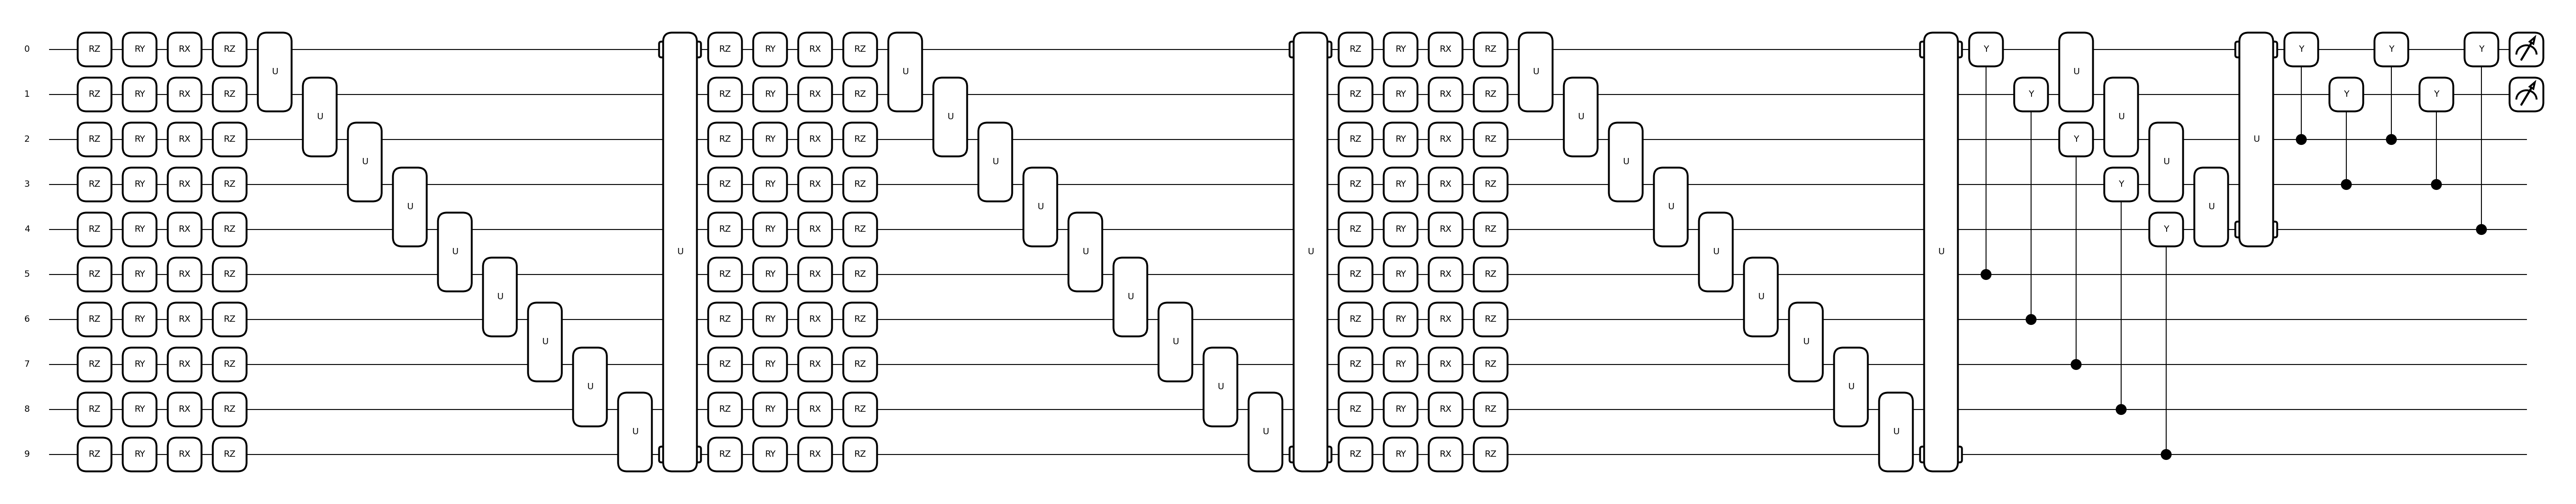

In [ ]:
plt.figure(figsize = (15,20))

dm_labels = [density_matrix(s) for s in state_labels]
params = np.random.uniform(size=35, requires_grad=True)



qml.draw_mpl(qcircuit)(params, Train_data[0], dm_labels[0])
plt.show()

In [ ]:
learning_rate = 5e-3
epochs = 1
batch_size = 32
# # initialize random weights
params = np.random.uniform(size=35, requires_grad=True)
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
best_val_accuracy = 0

In [ ]:
for it in range(epochs):
#     print(params[:10])
    for Xbatch, ybatch in iterate_minibatches(Train_data, Train_label, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, Train_data, Train_label, state_labels)
    accuracy_train = accuracy_score(Train_label, predicted_train)
    loss = cost(params, Train_data, Train_label, state_labels)

    predicted_test, fidel_test = test(params, Test_data, Test_label, state_labels)
    accuracy_test = accuracy_score(Test_label, predicted_test)

    if accuracy_test > best_val_accuracy:
        best_params = params.copy()
        best_val_accuracy = accuracy_test
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  1 | Loss: 0.188773 | Train accuracy: 0.497143 | Test accuracy: 0.450000


### chatgpt

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# Definir la simetrización sobre SO(2) usando discretización
def so2_symmetry(params, num_steps=10):
    angle_step = 2 * np.pi / num_steps
    @qml.qnode(dev)
    def circuit():
        for i in range(num_steps):
            angle = i * angle_step
            qml.RZ(angle, wires=0)
            # Aplicar la puerta U (por ejemplo, una rotación Rx)
            qml.RX(params, wires=0)
            # Aplicar la rotación inversa
            qml.RZ(-angle, wires=0)
        return qml.state()
    return circuit

# Definir el dispositivo
dev = qml.device('default.qubit', wires=1)

# Crear un circuito con la simetrización SO(2)
@qml.qnode(dev)
def variational_circuit(params):
    # Aplicar la simetrización
    so2_symmetry(params)
    return qml.expval(qml.PauliZ(0))

# Definir los parámetros iniciales
params = np.array(0.1, requires_grad=True)

# Ejecutar y optimizar el circuito
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
for i in range(steps):
    params, cost = opt.step_and_cost(variational_circuit, params)
    if (i + 1) % 10 == 0:
        print(f'Step {i+1}, Cost: {cost}, Params: {params}')

print('Optimized parameters:', params)
print('Optimized cost:', cost)


Step 10, Cost: 1.0, Params: 0.1
Step 20, Cost: 1.0, Params: 0.1
Step 30, Cost: 1.0, Params: 0.1
Step 40, Cost: 1.0, Params: 0.1
Step 50, Cost: 1.0, Params: 0.1
Step 60, Cost: 1.0, Params: 0.1
Step 70, Cost: 1.0, Params: 0.1
Step 80, Cost: 1.0, Params: 0.1
Step 90, Cost: 1.0, Params: 0.1
Step 100, Cost: 1.0, Params: 0.1
Optimized parameters: 0.1
Optimized cost: 1.0


/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


## SO(3)

The lie group SO(3) is the special orthogonal group of rotations in 3 dimensions. It is characterised by 3 rotation angles. The group may be represented by the following 3 matrices:

$U_x(\psi)=\begin{pmatrix}
1 & 0 & 0 \\
0 & \cos{\psi} & \sin{\psi} \\
0 & -\sin{\psi} & \cos{\psi} \\
\end{pmatrix}$

$U_y(\theta)=\begin{pmatrix}
 \cos{\theta} & 0 & -\sin{\theta} \\
0 & 1 & 0 \\
 -\sin{\theta} & 0 & \cos{\theta}
\end{pmatrix}$

$U_z(\phi)=\begin{pmatrix}
 \cos{\phi} & \sin{\phi}& 0 \\
-\sin{\phi} & \cos{\phi} & 0 \\
 0 & 0 & 1
\end{pmatrix}$

# SU(N)

## SU(2)

The Special Unitary group, $SU(n)$, corresponds to the set of all the n x n matrix rotations $U(\theta)$ with complex entries. Special comes from the fact that the rotations have determinant +1  and Unitary means that $U^† U = \mathbb{I}$. Where $U^\dagger=(U^*)^T$.

Furthermore, because SU(n) is a Lie group then it has to obey the following properties:
1. Rotation is linear. $U(v+w)=U(v)+U(w)$
2. Preserves lengths and angles. $(Uv)\cdot(Uw)= (Uv)^\dagger (Uw)= v^\dagger U^\dagger U w = v^\dagger w = v\cdot w$.
3. Preserves orientation. $det(U)=+1$

$$SU(n) = \{ U \in U(n), det(U)=1 \}$$


### SU(2) trainable

In [ ]:
class Spin_2(qml.operation.Operation):
    num_wires = 2

    @staticmethod
    def compute_decomposition(theta, wires):
        schur2 = np.array([
            [1, 0, 0, 0],
            [0, 1/np.sqrt(2), 1/np.sqrt(2), 0],
            [0, 0, 0, 1],
            [0, 1/np.sqrt(2), -1/np.sqrt(2), 0]
        ])

        return [qml.QubitUnitary(schur2, wires = wires),
                qml.ControlledPhaseShift(theta, wires = wires),
                qml.adjoint(qml.QubitUnitary)(schur2, wires = wires)]

def create_singlet(i, j):
    qml.Hadamard(wires=i)
    qml.PauliZ(wires=i)
    qml.CNOT(wires=[i, j])
    qml.PauliX(wires=j)

In [ ]:
def create_Heisenberg(N, J1, J2):
    H = sum([J1 * qml.PauliZ(i) @ qml.PauliZ((i + 1) % N) for i in range(N)])
    H += sum([J1 * qml.PauliX(i) @ qml.PauliX((i + 1) % N) for i in range(N)])
    H += sum([J1 * qml.PauliY(i) @ qml.PauliY((i + 1) % N) for i in range(N)])

    H += sum([J2 * qml.PauliZ(i) @ qml.PauliZ((i + 2) % N) for i in range(N)])
    H += sum([J2 * qml.PauliX(i) @ qml.PauliX((i + 2) % N) for i in range(N)])
    H += sum([J2 * qml.PauliY(i) @ qml.PauliY((i + 2) % N) for i in range(N)])

    return H

def prepare_init_state(N):
    for i in range(0, N, 2):
        create_singlet(i, i+1)

In [ ]:
dev = qml.device("default.qubit", wires=4)
N = 4

ham = create_Heisenberg(N, 1.0, 0.44)
# ham_sparse = qml.SparseHamiltonian(ham.sparse_matrix(), wires=range(N))

@qml.qnode(dev)
def circuit_2qubits(params):
    prepare_init_state(N)

#     p0 = [0.5,0.3,0.2]
#     qml.Rot(*p0, wires=0)
#     qml.Rot(*p0, wires=1)
#     qml.Rot(*p0, wires=2)
#     qml.Rot(*p0, wires=3)

    k = 0
    for l in range(4):
        for i in range(0, N, 2):
            Spin_2(params[k], wires=[i, (i + 1) % N])
            k += 1

        for i in range(1, N, 2):
            Spin_2(params[k], wires=[i, (i + 1) % N])
            k += 1

        for i in range(0, N):
            Spin_2(params[k], wires=[i, (i + 2) % N])
            k += 1

    return qml.expval(ham)

In [ ]:
#testing to see if the circuits is indeed SU(2) invariant under SU(2) rotation
Params = np.random.rand(50, requires_grad=False)

K = circuit_2qubits(Params)

print(K)

-6.137918095990246


In [ ]:
# run this cell afer induce an overall rotation in the circuit
@qml.qnode(dev)
def circuit_2qubits(params):
    prepare_init_state(N)

    #some arbitrary parameters
    p0 = [0.5,0.3,0.2]
    qml.Rot(*p0, wires=0)
    qml.Rot(*p0, wires=1)
    qml.Rot(*p0, wires=2)
    qml.Rot(*p0, wires=3)

    k = 0
    for l in range(4):
        for i in range(0, N, 2):
            Spin_2(params[k], wires=[i, (i + 1) % N])
            k += 1

        for i in range(1, N, 2):
            Spin_2(params[k], wires=[i, (i + 1) % N])
            k += 1

        for i in range(0, N):
            Spin_2(params[k], wires=[i, (i + 2) % N])
            k += 1

    return qml.expval(ham)

K = circuit_2qubits(Params)

print(K)

-6.137918095990245


In [ ]:
@qml.qnode(dev)
def circuit_2qubits(params):
    prepare_init_state(N)

    p0 = [0.5,0.3,0.2]
    qml.Rot(*p0, wires=0)
#     qml.Rot(*p0, wires=1)
#     qml.Rot(*p0, wires=2)
#     qml.Rot(*p0, wires=3)

    k = 0
    for l in range(4):
        for i in range(0, N, 2):
            Spin_2(params[k], wires=[i, (i + 1) % N])
            k += 1

        for i in range(1, N, 2):
            Spin_2(params[k], wires=[i, (i + 1) % N])
            k += 1

        for i in range(0, N):
            Spin_2(params[k], wires=[i, (i + 2) % N])
            k += 1

    return qml.expval(ham)

K = circuit_2qubits(Params)

print(K)

-5.552278744318179


### SU(2) untrainable

In [ ]:
dev = qml.device("default.qubit", wires=4)

def levi_civita(i,j,k):
    return (i-j)*(j-k)*(k-i)/2


@qml.qnode(dev, interface = 'autograd')
def qcircuit0(x,param, index):
    p0 = [0.1,0.3,0.2]

    qml.Rot(*x[0], wires=0)
    qml.Rot(*x[1], wires=1)
    qml.Rot(*x[2], wires=2)
    qml.Rot(*x[3], wires=3)

#     qml.Rot(*p0, wires=0)
#     qml.Rot(*p0, wires=1)
#     qml.Rot(*p0, wires=2)
#     qml.Rot(*p0, wires=3)

    #equivariant ops
    qml.exp(qml.SWAP(wires=[0,1]), coeff=-0.5j*param[0])
    qml.exp(qml.SWAP(wires=[2,3]), coeff=-0.5j*param[1])
    qml.exp(qml.SWAP(wires=[1,2]), coeff=-0.5j*param[2])
    qml.exp(qml.SWAP(wires=[3,0]), coeff=-0.5j*param[3])

#     print(qml.density_matrix([0,1]))
    if index==0:
        return qml.density_matrix([0,1])
    elif index==1:
        return qml.density_matrix([2,3])
    elif len(index)==2:
        return qml.density_matrix([index[1]])

dev2 = qml.device('default.mixed', wires=4)


@qml.qnode(dev2, interface = 'autograd')

def qcircuit1(rho,y, param):
    qml.QubitDensityMatrix(rho, wires=[0,1])

#     p0 = [0.1,0.3,0.2]
#     qml.Rot(*p0, wires=0)
#     qml.Rot(*p0, wires=1)
#     qml.exp(qml.SWAP(wires=[0,1]), coeff=-0.5j*param[0])

    return qml.expval(qml.Hermitian(y, wires=[0,1]))

def compute_phis(rho , rhos, P):
    phi1 = qml.matrix(np.trace(rho)*qml.Identity(wires = 0))/2
    phi2 = rhos[0]-phi1
    phi3 = rhos[1]-phi1
    Pauli = [qml.matrix(qml.PauliX(wires = 0)+qml.PauliX(wires = 1)),qml.matrix(qml.PauliY(wires = 0)+qml.PauliY(wires = 1)),qml.matrix(qml.PauliZ(wires = 0)+qml.PauliZ(wires = 1))]
    pauli =[qml.matrix(qml.PauliX(wires = 0)),qml.matrix(qml.PauliY(wires = 0)),qml.matrix(qml.PauliZ(wires = 0))]
    phi4 = np.zeros((2,2),dtype='complex128')
    for i,j,k in itertools.permutations([0,1,2]):
        phi4+= np.trace(rho*Pauli[i]*Pauli[j])*levi_civita(i,j,k)*pauli[k]

    return phi1+P[0]*phi2+P[1]*phi3+P[2]*phi4

In [ ]:
def full_circuit(X, Params, VectorParams):

    Observ = qml.matrix(qml.SWAP(wires=[0,1]))
    densities = np.zeros((2,4,4),dtype='complex128')
    densities_single = np.zeros((4,2,2),dtype='complex128')
    for i in range(2):
        densities[i] = qcircuit0(x = X, param = Params,index=i)
    for i in range(4):
        densities_single[i] = qcircuit0(x = X, param = Params,index=[2,i])
    phi0 = compute_phis(densities[0],densities_single[0:2],VectorParams[0])
    phi1 = compute_phis(densities[1],densities_single[2:4],VectorParams[1])
    Rho = np.kron(phi0,phi1)
#     print(Rho)
#    print(qml.math.purity(Rho, [0, 1]))
    out = qcircuit1(Rho,y=Observ,param = [Params[-1]])

    return out

In [ ]:
import itertools

Params = np.random.rand(5, requires_grad=False)
VectorParams = np.random.rand(2,3, requires_grad=False)
X = np.random.rand(4, 3, requires_grad=False)

K = full_circuit(X, Params, VectorParams)
print(K)

0.9784502304804135


In [ ]:
@qml.qnode(dev, interface = 'autograd')
def qcircuit0(x,param, index):
    p0 = [0.1,0.3,0.2]

    qml.Rot(*x[0], wires=0)
    qml.Rot(*x[1], wires=1)
    qml.Rot(*x[2], wires=2)
    qml.Rot(*x[3], wires=3)

    qml.Rot(*p0, wires=0)
    qml.Rot(*p0, wires=1)
    qml.Rot(*p0, wires=2)
    qml.Rot(*p0, wires=3)

    #equivariant ops
    qml.exp(qml.SWAP(wires=[0,1]), coeff=-0.5j*param[0])
    qml.exp(qml.SWAP(wires=[2,3]), coeff=-0.5j*param[1])
    qml.exp(qml.SWAP(wires=[1,2]), coeff=-0.5j*param[2])
    qml.exp(qml.SWAP(wires=[3,0]), coeff=-0.5j*param[3])

#     print(qml.density_matrix([0,1]))
    if index==0:
        return qml.density_matrix([0,1])
    elif index==1:
        return qml.density_matrix([2,3])
    elif len(index)==2:
        return qml.density_matrix([index[1]])

K = full_circuit(X, Params, VectorParams)
print(K)

0.899925516100019


In [ ]:
qml.draw_mpl(full_circuit)(X,params,VectorParams)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
@qml.qnode(dev2, interface = 'autograd')
def qcircuit1(rho,y, param):
    qml.QubitDensityMatrix(rho, wires=[0,1])

#     p0 = [0.1,0.3,0.2]
#     qml.Rot(*p0, wires=0)
#     qml.Rot(*p0, wires=1)
#     qml.exp(qml.SWAP(wires=[0,1]), coeff=-0.5j*param[0])

    return qml.expval(qml.Hermitian(y, wires=[0,1]))

K = full_circuit(X, Params, VectorParams)
print(K)

0.899925516100019


## SU(3)